In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [89]:
data = pd.read_csv('../data/regional_xgboost_data.csv')
enc = pd.read_csv('../data/regional_datasets/xgboost/enc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
esc = pd.read_csv('../data/regional_datasets/xgboost/esc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
midatl = pd.read_csv('../data/regional_datasets/xgboost/mid_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
mount = pd.read_csv('../data/regional_datasets/xgboost/mountain_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
ne = pd.read_csv('../data/regional_datasets/xgboost/new_england_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
pac = pd.read_csv('../data/regional_datasets/xgboost/pacific_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
satl = pd.read_csv('../data/regional_datasets/xgboost/south_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
wnc = pd.read_csv('../data/regional_datasets/xgboost/wnc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
wsc = pd.read_csv('../data/regional_datasets/xgboost/wsc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')

## Processing Data

In [121]:
def process(data): 
    df = data.sort_values(by=['date', 'location_key']).drop(columns = ['Unnamed: 1', 'region', 'year', 'month', 'day'] + 
                                                            [col for col in data.columns if (col[:12] == 'location_key') and (len(col) > 12)])
    for col in df.columns:
        if (col[0].isdigit() == False) & (col != 'location_key'):
            df['lag1_' + str(col)] = df.groupby('location_key')[str(col)].shift(1)
    colsremain = ['new_confirmed', 'location_key'] + [col for col in df.columns if (col[0].isdigit()) or (col[:4] == 'lag1')]
    return df[colsremain].dropna()
    

## Parameter Tuning

East North Central
MASE:  0.4831123042177132
RMSE:  2553.5886907912777
MAE:  1224.4079305154305
Train MASE:  0.2693347709901454
{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50}
East South Central
MASE:  0.3607911616835455
RMSE:  1173.2954064063345
MAE:  548.0202532870098
Train MASE:  0.4024462253889666
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Mid-Atlantic
MASE:  0.5445087382952511
RMSE:  2989.398421779238
MAE:  1608.1577180748184
Train MASE:  0.2371196284295325
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
Mountain
MASE:  0.4837195276147638
RMSE:  1427.2123087300156
MAE:  498.1414803725736
Train MASE:  0.2998539827763569
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
New England
MASE:  0.24269451478407242
RMSE:  559.4739155282709
MAE:  228.0650103678676
Train MASE:  0.17513287642690623
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Pacific
MASE:  0.795246251954921
RMSE:  10609.954159438732
MAE:  4348.64540327456
Train M

<Figure size 1500x500 with 0 Axes>

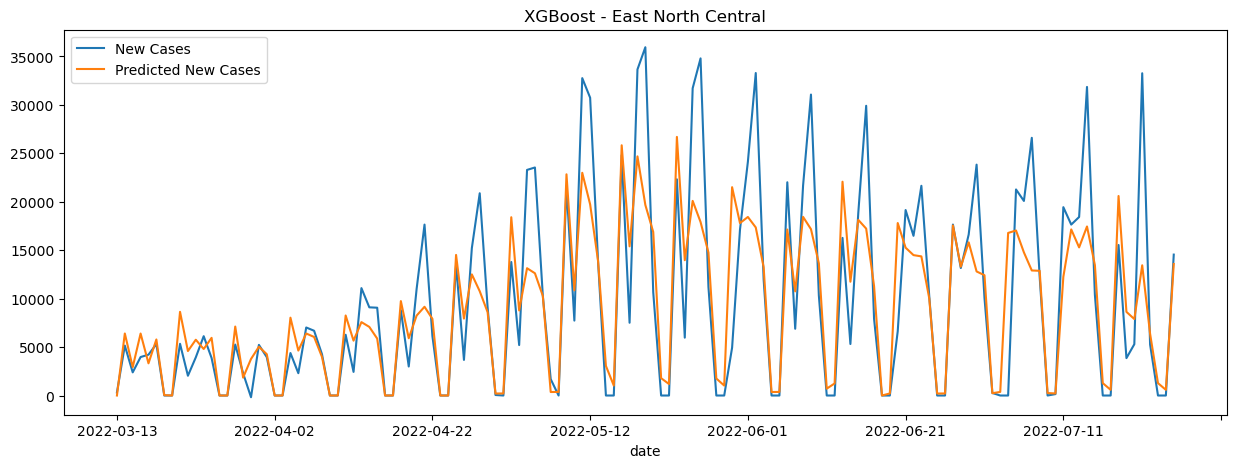

<Figure size 1500x500 with 0 Axes>

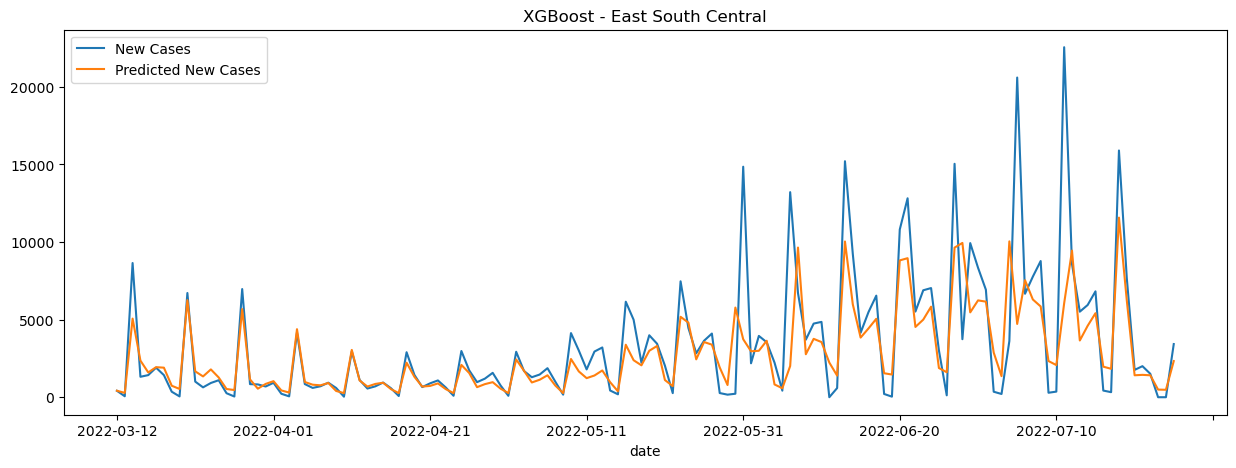

<Figure size 1500x500 with 0 Axes>

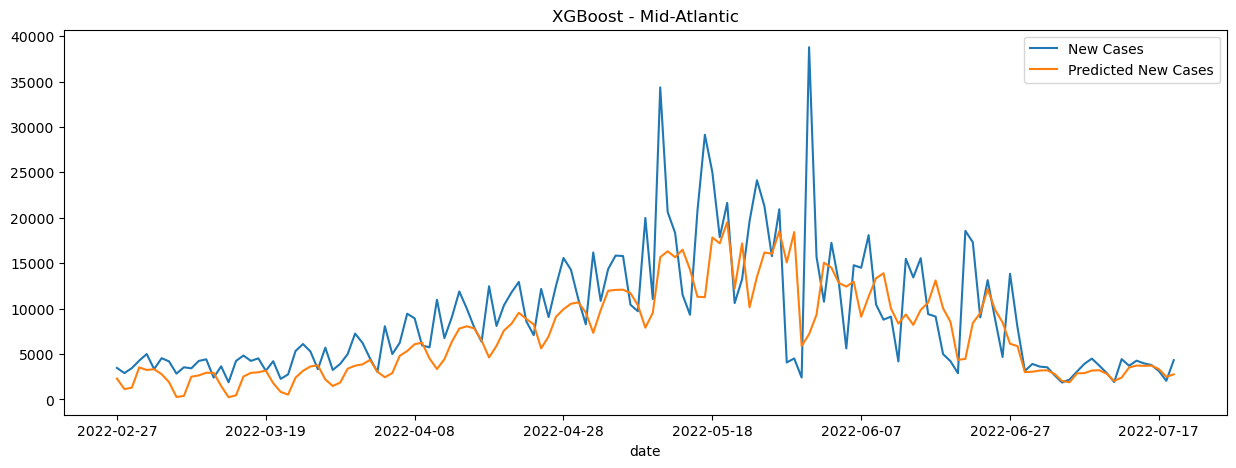

<Figure size 1500x500 with 0 Axes>

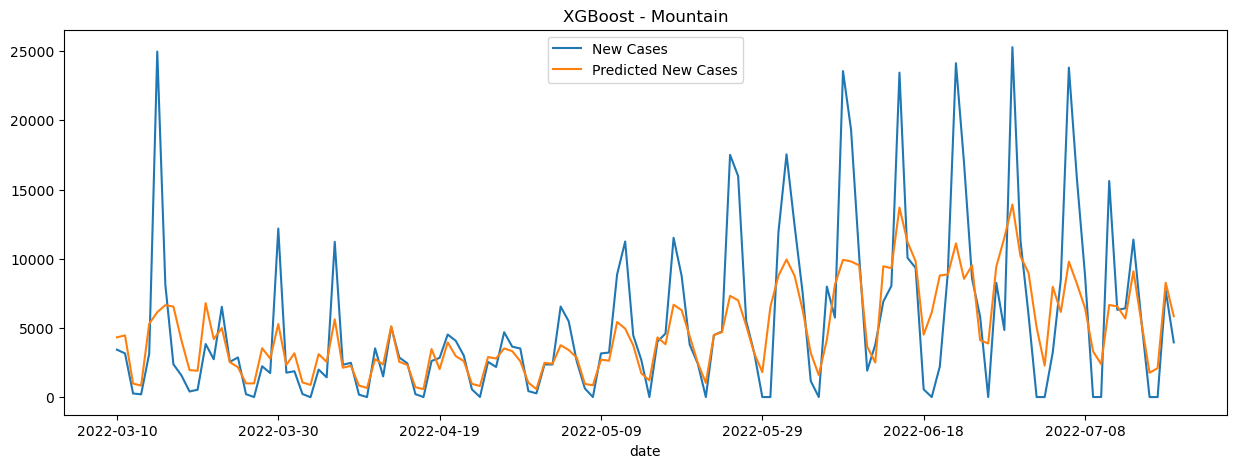

<Figure size 1500x500 with 0 Axes>

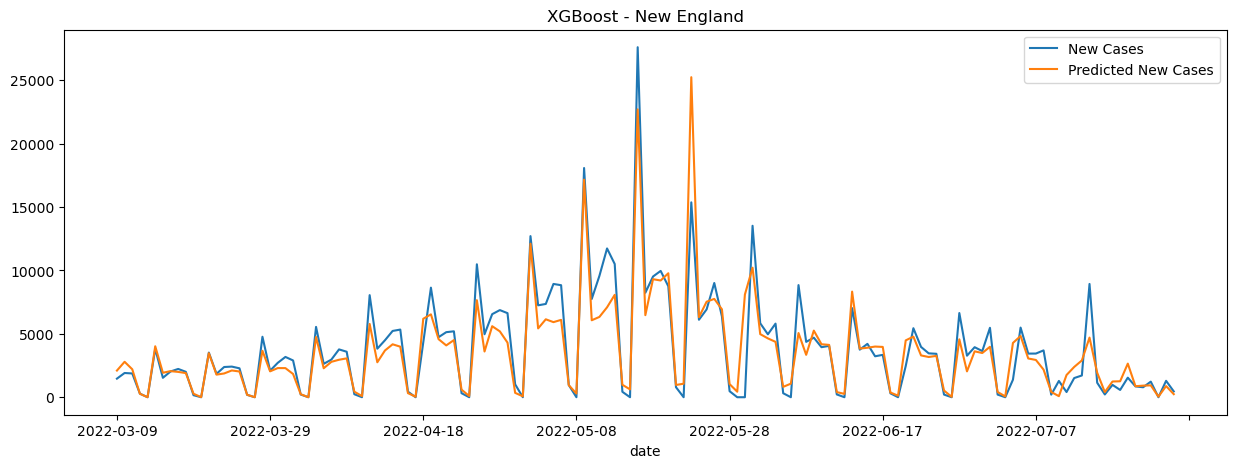

<Figure size 1500x500 with 0 Axes>

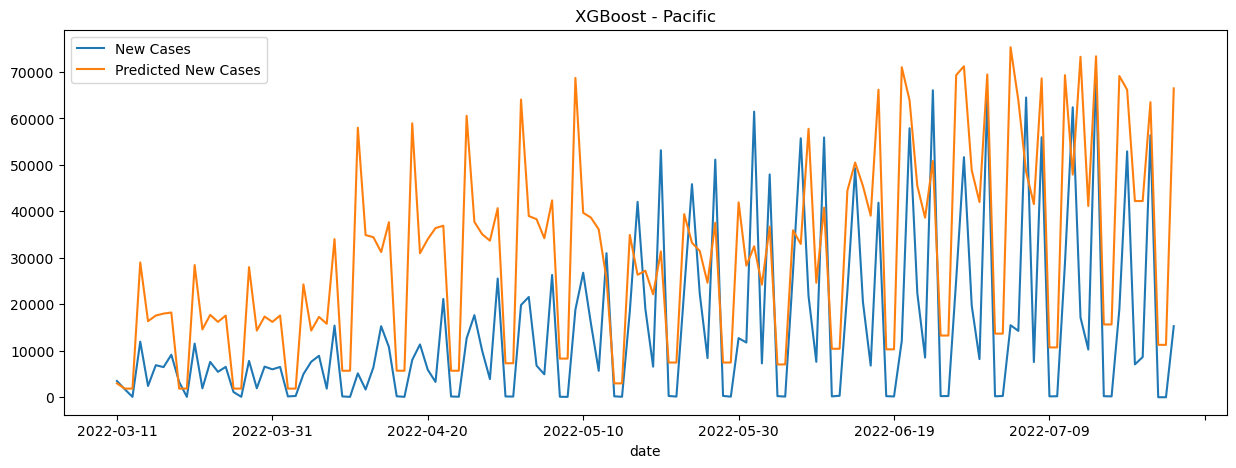

<Figure size 1500x500 with 0 Axes>

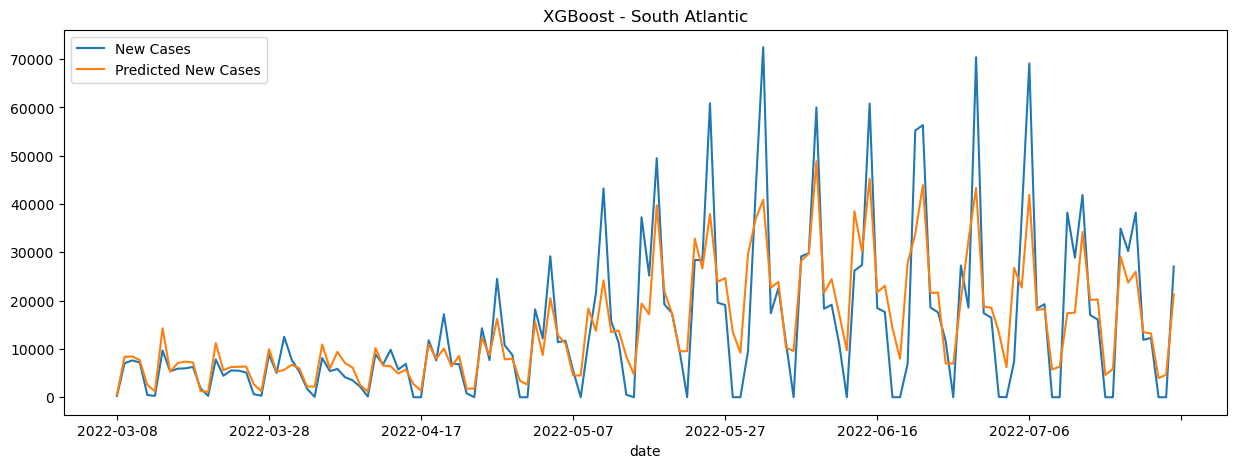

<Figure size 1500x500 with 0 Axes>

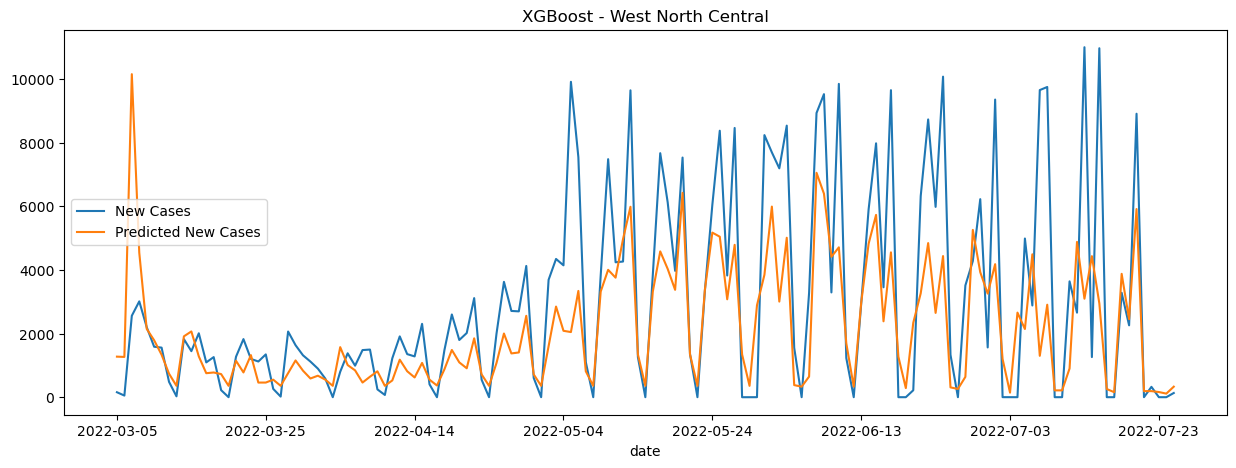

<Figure size 1500x500 with 0 Axes>

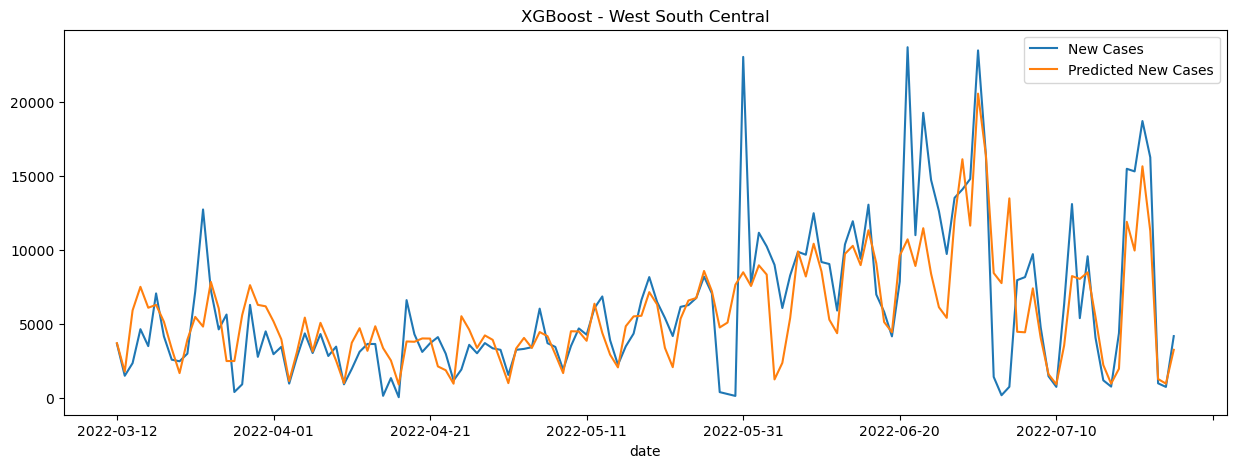

In [130]:
param_grid = {'n_estimators': [25, 50, 100, 200, 300],
              'learning_rate': [0.1, 0.15, 0.25, 0.3, 0.5],
              'max_depth': [2, 3, 4, 5]}
              # 'subsample': [0.5, 0.75, 1.0]}
predlist = dict()
paramlist = dict()
from sklearn.metrics import make_scorer
mas_error = make_scorer(mean_absolute_scaled_error)
for data in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    region = data.region.unique()[0]
    print(region)
    data = process(data)
    data = data.sort_values(by=['date', 'location_key'])
    df = pd.get_dummies(data)
    df['month'] = pd.to_datetime(df.index).month
    df['year'] = pd.to_datetime(df.index).year
    df['day_of_week'] = pd.to_datetime(df.index).day_of_week
    # df['new_confirmed'] = df['new_confirmed'].replace(0, np.nan)
    # df['log_target'] = np.log(df.new_confirmed)
    # df.dropna(inplace = True)
    # df.drop(columns = ['new_confirmed'], inplace = True)
    model = xgb.XGBRegressor()
    y = df.new_confirmed
    X = df.drop(columns = ['new_confirmed'])
    size = round(data.shape[0]*0.15)
    model.fit(X, y)
    stats = pd.DataFrame({'importance': model.feature_importances_}, index=X.columns)
    stats = stats.sort_values('importance', ascending=False)
    preds = stats[:10].index.tolist()
    X = df[preds]
    predlist[region] = preds
    Xtrain = X.iloc[:-size]
    Xtest = X.iloc[-size:]
    ytrain = y.iloc[:-size]
    ytest = y.iloc[-size:]
    est = xgb.XGBRegressor()
    grid_result = GridSearchCV(estimator = est,
                        param_grid = param_grid,
                        cv = 5,
                        scoring = 'neg_root_mean_squared_error').fit(Xtrain, ytrain)
    model = xgb.XGBRegressor(n_estimators = grid_result.best_params_['n_estimators'],
                             learning_rate = grid_result.best_params_['learning_rate'],
                             max_depth = grid_result.best_params_['max_depth']).fit(Xtrain, ytrain)
    train_pred = model.predict(Xtrain)
    test_pred = model.predict(Xtest)
    test_pred = np.array([max(0, x) for x in test_pred])
    plt.figure(figsize = (15,5))
#     pd.concat([pd.concat([ytrain, ytest]).reset_index().new_confirmed, 
#            pd.DataFrame(np.concatenate((train_pred, test_pred)))[0]], axis = 1).plot(figsize = (15,5))
    # plt.plot(ytest.reset_index().drop(columns = 'date'))
    # plt.plot(test_pred)
    pd.DataFrame({'New Cases': ytest, 'Predicted New Cases': test_pred}).groupby('date').sum().plot(figsize = (15,5))
    # plt.legend(['actual', 'forecast'])
#     plt.axvline(x = len(ytrain), color = 'green')
    plt.title('XGBoost - ' + region)
    print('MASE: ', mean_absolute_scaled_error(ytest, test_pred, y_train = ytrain))
    print('RMSE: ', mean_squared_error(ytest, test_pred, squared = False))
    print('MAE: ', mean_absolute_error(ytest, test_pred))
    print('Train MASE: ', mean_absolute_scaled_error(ytrain, train_pred, y_train = ytrain))
    paramlist[region] = grid_result.best_params_
    print(grid_result.best_params_)
    

In [144]:
from collections import Counter
l = []
for items in predlist:
    for x in predlist[items]:
        l.append(x)
Counter(l)

Counter({'7_day_shift': 8,
         '7_day_avg': 9,
         'lag1_international_travel_controls': 2,
         'day_of_week': 9,
         '1_day_shift': 6,
         'lag1_facial_coverings': 1,
         'lag1_cumulative_hospitalized_patients': 4,
         'lag1_new_vaccine_doses_administered_moderna': 2,
         'location_key_US_MI': 1,
         'lag1_minimum_temperature_celsius': 1,
         'location_key_US_AL': 1,
         'lag1_cumulative_vaccine_doses_administered_moderna': 1,
         '2_day_shift': 2,
         'lag1_stay_at_home_requirements': 1,
         'lag1_contact_tracing': 1,
         'month': 4,
         'lag1_new_hospitalized_patients': 2,
         'year': 1,
         'lag1_cumulative_persons_vaccinated': 3,
         'lag1_public_transport_closing': 2,
         'lag1_cumulative_vaccine_doses_administered_janssen': 2,
         'lag1_new_persons_vaccinated': 2,
         'lag1_new_persons_fully_vaccinated_pfizer': 1,
         'lag1_cumulative_confirmed': 2,
         'lag1_s

## Additional Tuning (not used in report or presentation)

East North Central
MASE:  0.6677934963769173
RMSE:  3191.4673206899483
MAE:  1692.467042905313
{'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 1, 'subsample': 0.6}
East South Central
MASE:  0.5236096326077521
RMSE:  1337.959514638723
MAE:  795.3317984460627
{'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 1, 'subsample': 0.6}
Mid-Atlantic
MASE:  0.5129781720611829
RMSE:  2815.1583572951113
MAE:  1515.035018881162
{'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 1, 'subsample': 0.6}
Mountain
MASE:  0.5030462736049478
RMSE:  1291.6467447968105
MAE:  518.0444475027374
{'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 1, 'subsample': 0.6}
New England
MASE:  0.27128756401779647
RMSE:  573.6589431424837
MAE:  254.93448484173481
{'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 1, 'subsample': 0.6}
Pacific
MASE:  0.6239993067785323
RMSE:  7465.0677423745765
MAE:  3412.2156632594797
{'colsample_bytree': 0.6, 'gamma': 0, 'min_child_weight': 1, 'subsam

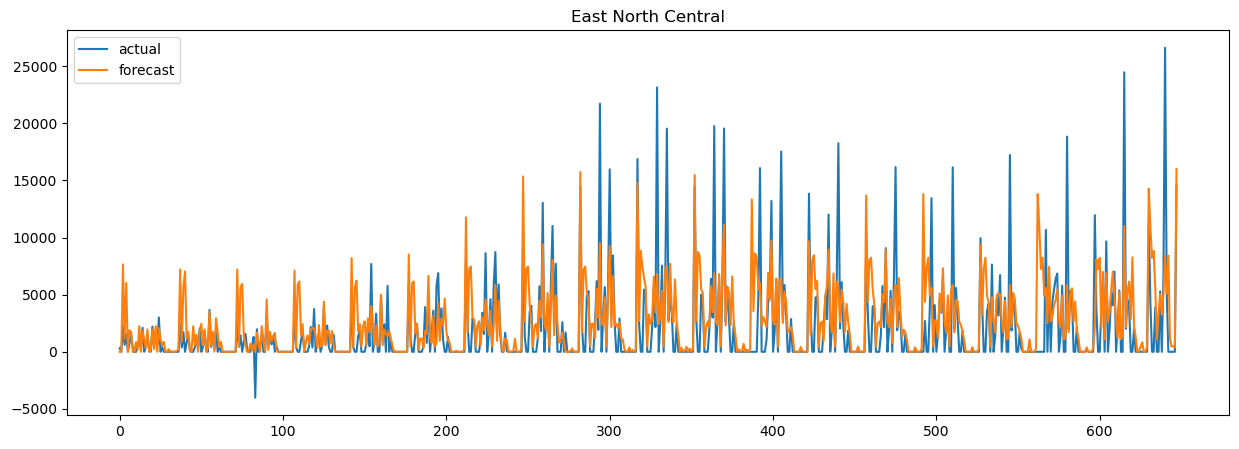

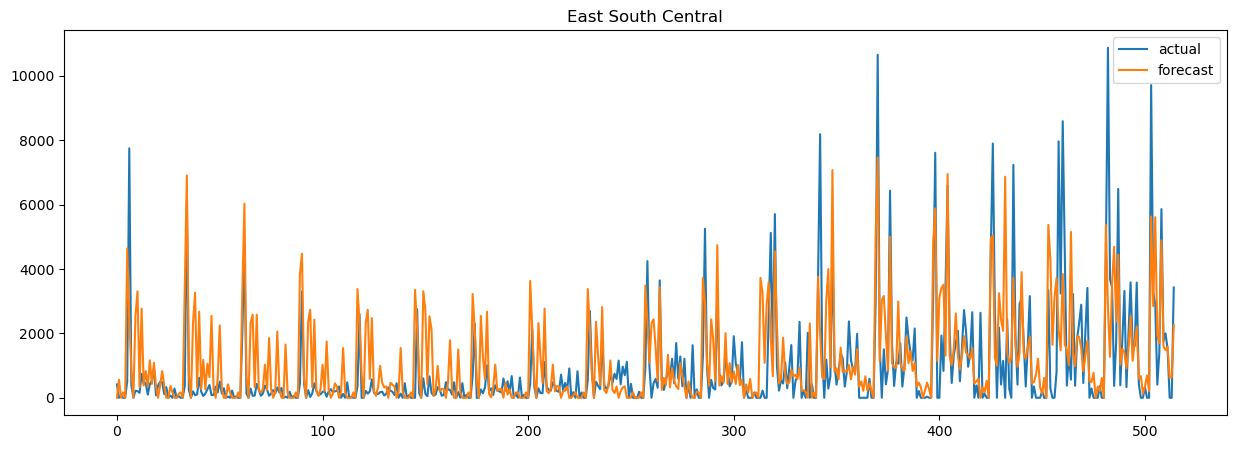

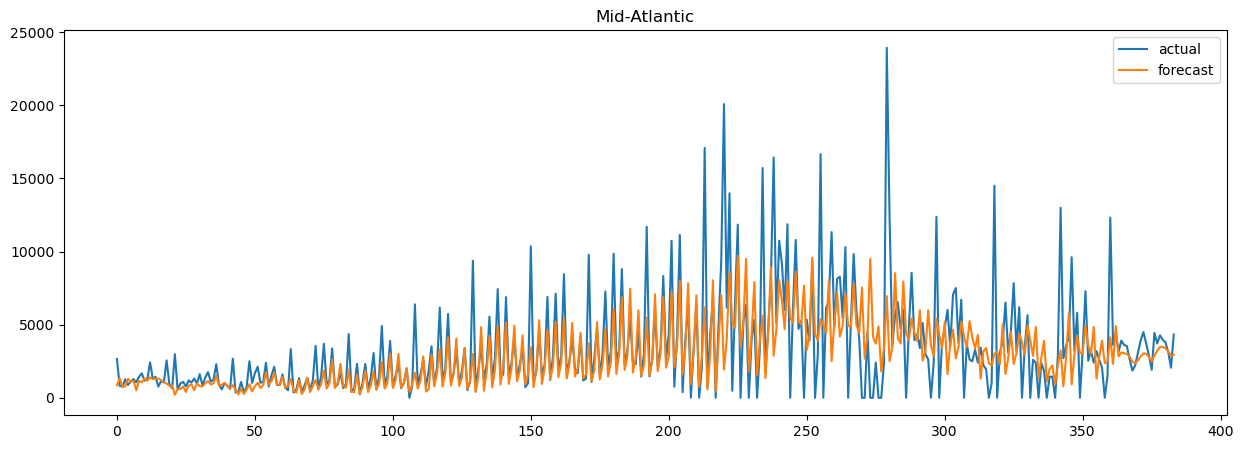

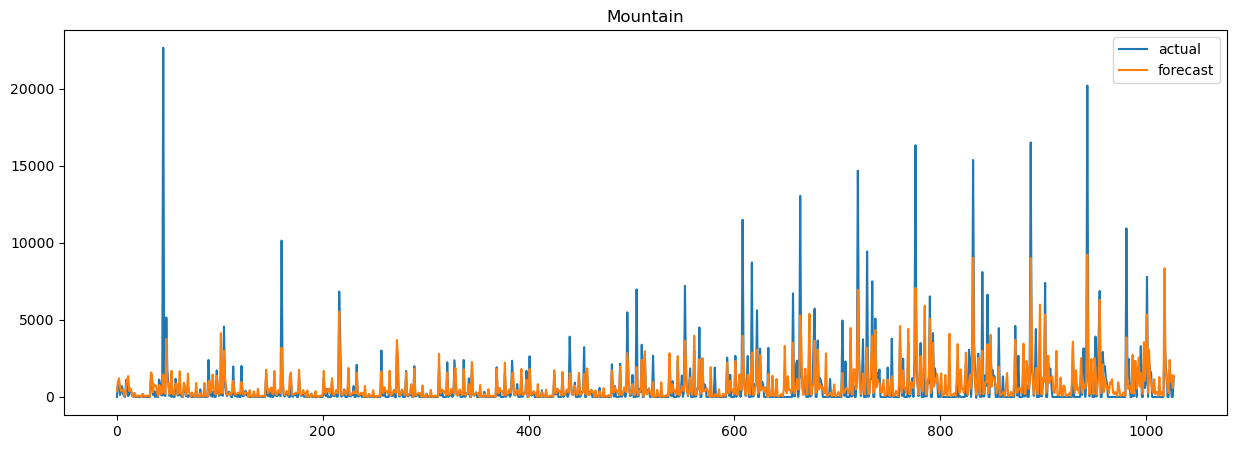

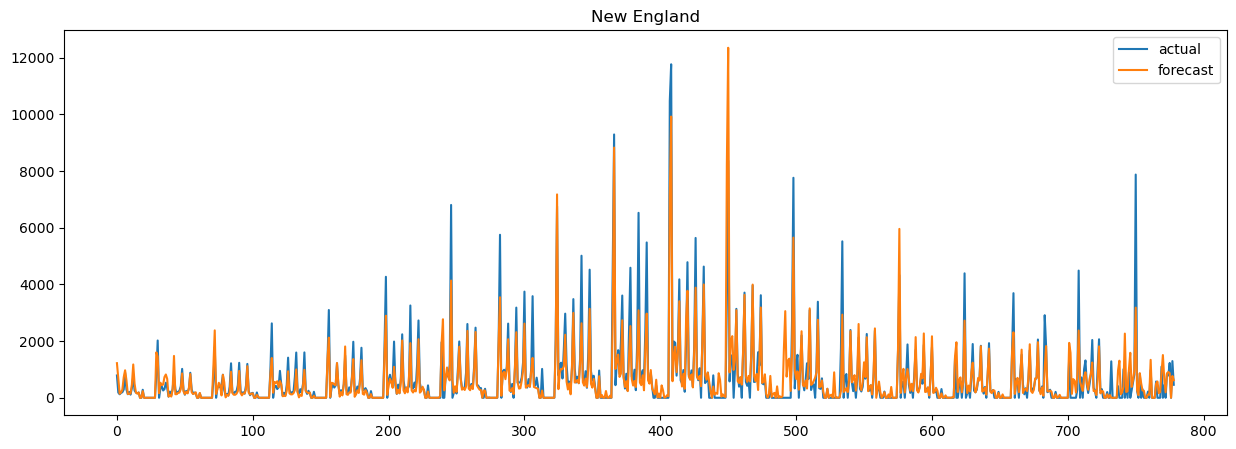

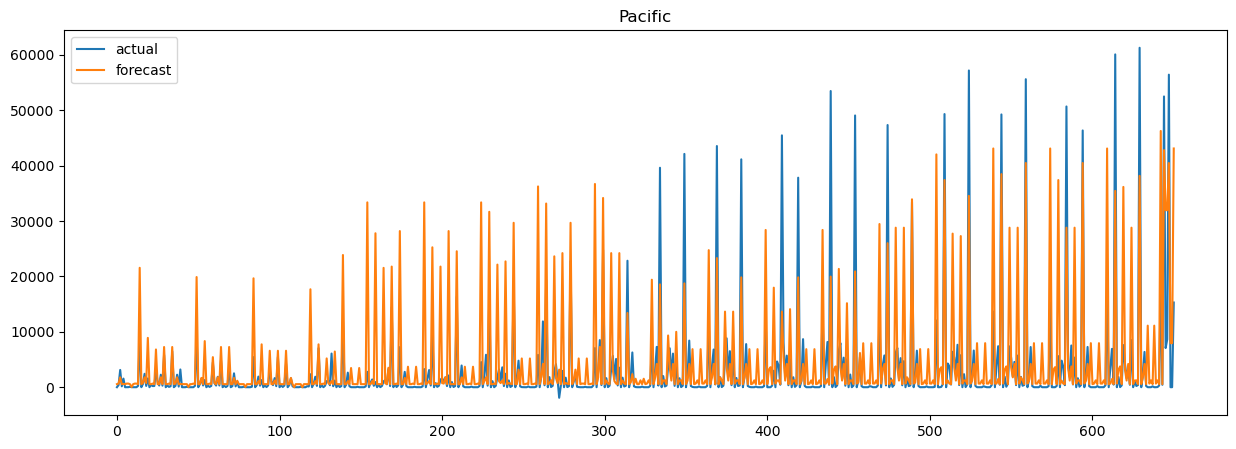

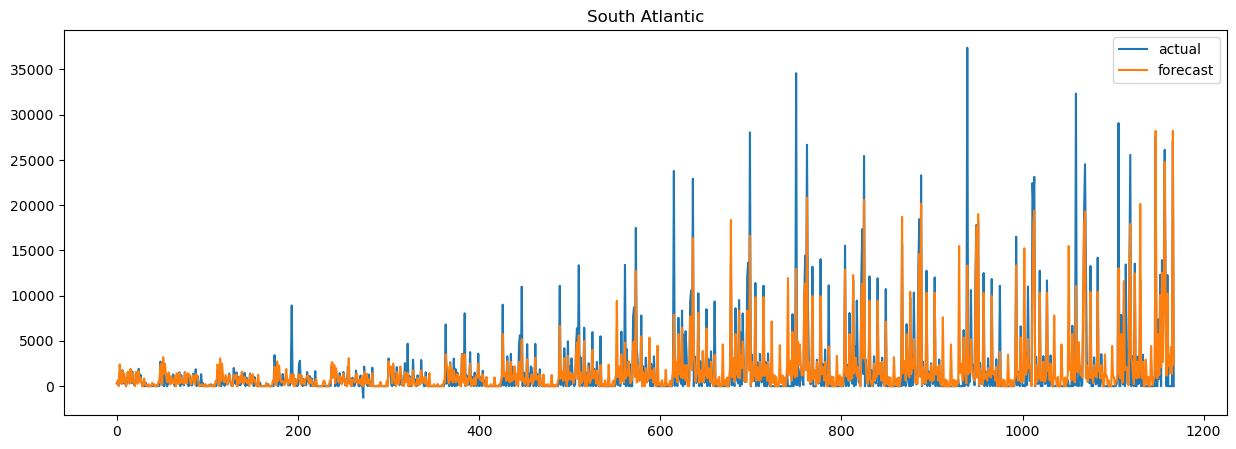

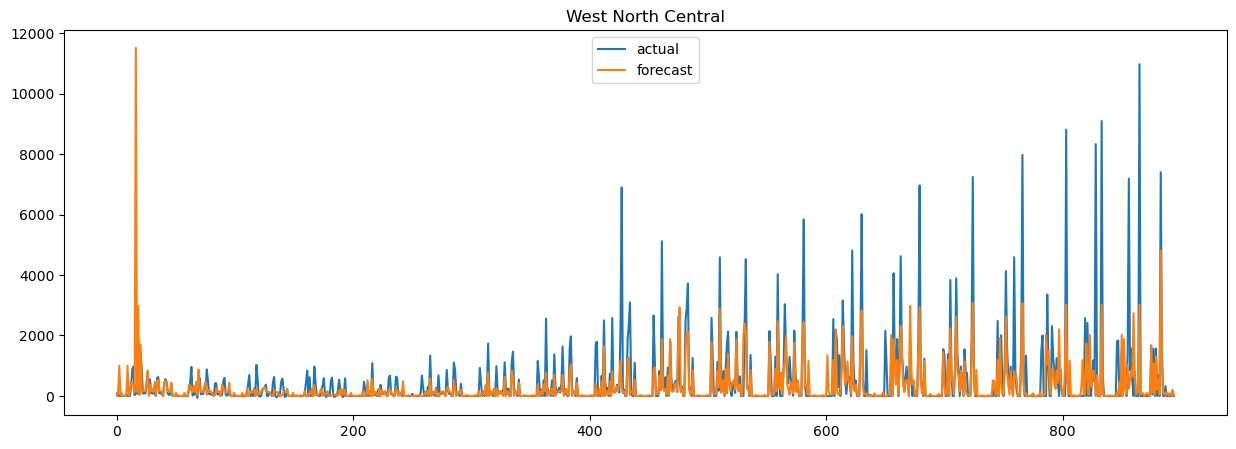

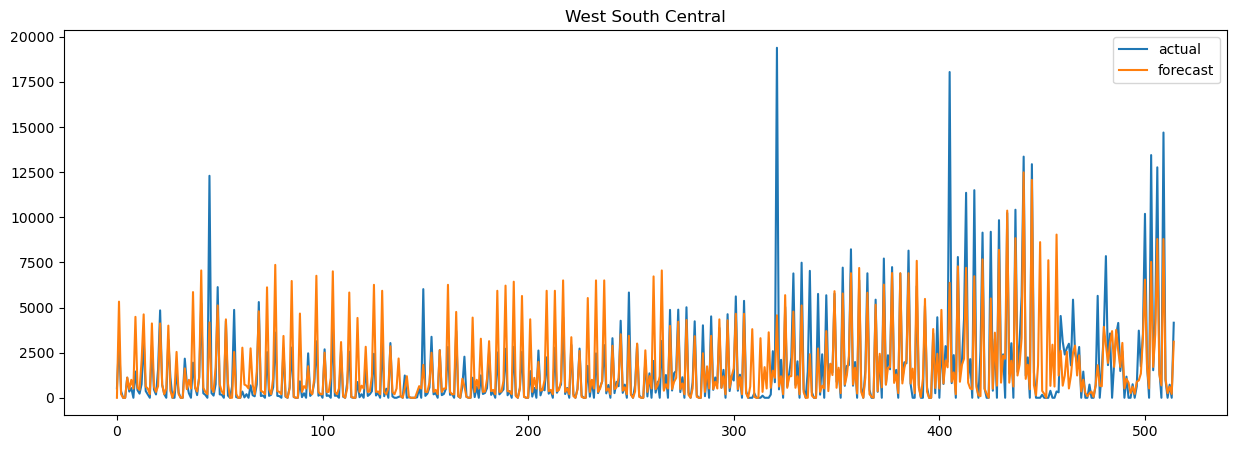

In [147]:
param_grid = {
    # 'n_estimators': [25, 50, 100, 300, 500],
    # 'learning_rate': [0.1, 0.15, 0.25, 0.3, 0.5],
    # 'max_depth': [2, 3, 5, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}
from sklearn.metrics import make_scorer
mas_error = make_scorer(mean_absolute_scaled_error)
for data in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    region = data.region.unique()[0]
    print(region)
    data = process(data)
    data = data.sort_values(by=['date', 'location_key'])
    df = pd.get_dummies(data)
    df['month'] = pd.to_datetime(df.index).month
    df['year'] = pd.to_datetime(df.index).year
    df['day_of_week'] = pd.to_datetime(df.index).day_of_week
    # df['new_confirmed'] = df['new_confirmed'].replace(0, np.nan)
    # df['log_target'] = np.log(df.new_confirmed)
    # df.dropna(inplace = True)
    # df.drop(columns = ['new_confirmed'], inplace = True)
    model = xgb.XGBRegressor()
    y = df.new_confirmed
    X = df.drop(columns = ['new_confirmed'])
    size = round(data.shape[0]*0.15)
    model.fit(X, y)
    stats = pd.DataFrame({'importance': model.feature_importances_}, index=X.columns)
    stats = stats.sort_values('importance', ascending=False)
    preds = stats[:10].index.tolist()
    X = df[preds]
    Xtrain = X.iloc[:-size]
    Xtest = X.iloc[-size:]
    ytrain = y.iloc[:-size]
    ytest = y.iloc[-size:]
    est = xgb.XGBRegressor()
    grid_result = GridSearchCV(estimator = est,
                        param_grid = param_grid,
                        cv = 5,
                        scoring = mas_error).fit(Xtrain, ytrain)
    model = xgb.XGBRegressor(
    n_estimators=paramlist[region]['n_estimators'],
    learning_rate=paramlist[region]['learning_rate'],
    max_depth=paramlist[region]['max_depth'],
    subsample=grid_result.best_params_.get('subsample', 1.0), # Providing a default value if not set by grid search
    colsample_bytree=grid_result.best_params_.get('colsample_bytree', 1.0), # Providing a default value
    min_child_weight=grid_result.best_params_.get('min_child_weight', 1), # Providing a default value
    gamma=grid_result.best_params_.get('gamma', 0) # Providing a default value
).fit(Xtrain, ytrain)
    train_pred = model.predict(Xtrain)
    test_pred = model.predict(Xtest)
    test_pred = np.array([max(0, x) for x in test_pred])
    plt.figure(figsize = (15,5))
#     pd.concat([pd.concat([ytrain, ytest]).reset_index().new_confirmed, 
#            pd.DataFrame(np.concatenate((train_pred, test_pred)))[0]], axis = 1).plot(figsize = (15,5))
    pd.DataFrame({'New Cases': test.y, 'Predicted New Cases': test_pred.yhat}).set_index(test.ds).plot(figsize = (15,5))
    plt.legend(['actual', 'forecast'])
#     plt.axvline(x = len(ytrain), color = 'green')
    plt.title(region)
    print('MASE: ', mean_absolute_scaled_error(ytest, test_pred, y_train = ytrain))
    print('RMSE: ', mean_squared_error(ytest, test_pred, squared = False))
    print('MAE: ', mean_absolute_error(ytest, test_pred))
    print(grid_result.best_params_)
    